In [63]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re


In [64]:
# Path for the cleaned data
cleaned_data_dir = Path(r"C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\MLP\synthetic_data\BC20241017_HZ_Nozzle2\clean")

# Nozzle 2 special
group_length = 13

In [65]:
def numeric_then_alpha_key(p: Path):
    """
    Sort numerically by the first integer in the stem if present; otherwise
    fall back to case-insensitive alphabetical by full name.
    """
    m = re.search(r'\d+', p.stem)
    if m:
        return (0, int(m.group(0)))          # group 0 = first number
    else:
        return (1, p.name.lower())           # non-numeric go after (or before if you swap 0/1)


In [66]:
# Get all csv files
csv_files = sorted(cleaned_data_dir.glob("*.csv"), key=numeric_then_alpha_key)
if not csv_files:
    print(f"Skip {cleaned_data_dir.name}: no csv files.")
    

In [67]:
number_of_groups = len(csv_files)//group_length 

print("Number of groups to compare: ",number_of_groups)


Number of groups to compare:  5


In [ ]:
from pathlib import Path
import time

def label_from_file(file_path):
    stem = Path(file_path).stem
    m = re.search(r"(\d+)", stem)
    return f"T{int(m.group(1))}" if m else stem

def label_sort_key(label):
    m = re.search(r"(\d+)", label)
    return (int(m.group(1)), label) if m else (10**9, label)

# Metrics restored (including s and t0)
METRICS = [
    {"key": "s", "scale": 1e3, "unit": "ms", "positive_only": True},
    {"key": "t0", "scale": 1e3, "unit": "ms", "positive_only": False},
    {"key": "k_sqrt", "scale": 1.0, "unit": "", "positive_only": True},
    {"key": "k_quarter", "scale": 1.0, "unit": "", "positive_only": True},
]

# Safeguards
ENABLE_PLOTS = False            # stats-only by default
MAX_GROUPS = None               # e.g. 3 for quick check
MAX_FILES_PER_GROUP = group_length
MAX_POINTS_PER_FILE = 50000
MAX_BINS = 60
SEED = 42
rng = np.random.default_rng(SEED)

metric_keys = [m["key"] for m in METRICS]
metric_cfg = {m["key"]: m for m in METRICS}
rows = []
t_start = time.perf_counter()

group_starts = list(range(0, len(csv_files), group_length))
if MAX_GROUPS is not None:
    group_starts = group_starts[:MAX_GROUPS]

for g_idx, start in enumerate(group_starts, start=1):
    group_files = csv_files[start:start + group_length]
    group_files = group_files[:MAX_FILES_PER_GROUP]
    if not group_files:
        continue

    print(f"Processing Group {g_idx}: {len(group_files)} files")

    per_file_metric_vals = {k: [] for k in metric_keys}

    for file_path in group_files:
        df_file = pd.read_csv(file_path, usecols=lambda c: c in metric_keys)
        label = label_from_file(file_path)

        for key in metric_keys:
            if key not in df_file.columns:
                continue

            vals = pd.to_numeric(df_file[key], errors="coerce").to_numpy()
            vals = vals[np.isfinite(vals)]

            cfg = metric_cfg[key]
            if cfg["positive_only"]:
                vals = vals[vals > 0.0]

            if vals.size < 2:
                continue

            if vals.size > MAX_POINTS_PER_FILE:
                idx = rng.choice(vals.size, size=MAX_POINTS_PER_FILE, replace=False)
                vals = vals[idx]

            vals_scaled = vals * cfg["scale"]
            per_file_metric_vals[key].append((label, vals_scaled))

            rows.append({
                "group": f"Group {g_idx}",
                "label": label,
                "metric": key,
                "unit": cfg["unit"],
                "n": int(vals_scaled.size),
                "mean": float(np.mean(vals_scaled)),
                "std": float(np.std(vals_scaled, ddof=1)) if vals_scaled.size > 1 else 0.0,
                "median": float(np.median(vals_scaled)),
                "p05": float(np.percentile(vals_scaled, 5)),
                "p95": float(np.percentile(vals_scaled, 95)),
                "min": float(np.min(vals_scaled)),
                "max": float(np.max(vals_scaled)),
            })

    if ENABLE_PLOTS:
        for key in metric_keys:
            valid = per_file_metric_vals[key]
            if not valid:
                continue

            valid.sort(key=lambda x: label_sort_key(x[0]))
            all_vals = np.concatenate([v for _, v in valid])
            bins = np.histogram_bin_edges(all_vals, bins="fd")
            if bins.size < 8:
                bins = np.histogram_bin_edges(all_vals, bins=20)
            if bins.size > (MAX_BINS + 1):
                bins = np.linspace(all_vals.min(), all_vals.max(), MAX_BINS + 1)

            colors = plt.colormaps["turbo"](np.linspace(0.08, 0.92, len(valid)))
            fig, ax = plt.subplots(figsize=(10, 5.2))
            left = bins[:-1]
            widths = np.diff(bins)
            sub_w = widths / max(len(valid), 1)

            for i, (lbl, vals_scaled) in enumerate(valid):
                counts, _ = np.histogram(vals_scaled, bins=bins)
                x = left + i * sub_w
                ax.bar(x, counts, width=sub_w * 0.94, align="edge", color=colors[i], edgecolor="white", linewidth=0.3, alpha=0.95, label=lbl)

            unit = metric_cfg[key]["unit"]
            xlabel = f"{key} ({unit})" if unit else key
            ax.set_xlabel(xlabel)
            ax.set_ylabel("Count")
            ax.set_title(f"Group {g_idx}: {key} split-bin distribution by file")
            ax.grid(axis="y", alpha=0.25)
            ax.legend(title="File", fontsize=8, ncol=2, frameon=False)
            plt.tight_layout()
            plt.show()
            plt.close(fig)

stats_df = pd.DataFrame(rows)
stats_df = stats_df.sort_values(["group", "metric", "label"], key=lambda s: s.map(label_sort_key) if s.name=="label" else s).reset_index(drop=True)
elapsed = time.perf_counter() - t_start
print(f"Done in {elapsed:.2f}s. Rows: {len(stats_df)}")
stats_df


Processing Group 1: 13 files
Processing Group 2: 13 files
Processing Group 3: 13 files
Processing Group 4: 13 files
Processing Group 5: 13 files
Done in 0.22s. Rows: 260


,group,label,metric,unit,n,mean,std,median,p05,p95,min,max
0,Group 1,T1,k_quarter,,26,430.681985,28.707274,425.292119,392.184093,477.961212,390.781412,482.951561
1,Group 1,T2,k_quarter,,27,440.453185,25.285044,439.693896,409.800577,484.473388,386.806054,508.855262
2,Group 1,T3,k_quarter,,8,422.612701,27.489563,413.702772,400.153848,466.602458,397.865327,484.018444
3,Group 1,T4,k_quarter,,10,492.226833,29.553422,489.298276,463.858633,539.836100,463.101526,565.295888
4,Group 1,T5,k_quarter,,9,497.254739,32.624749,495.947584,452.240465,543.540801,444.479383,554.018505
...,...,...,...,...,...,...,...,...,...,...,...,...
255,Group 5,T61,t0,ms,34,0.525427,0.037019,0.521746,0.471106,0.582424,0.451468,0.588317
256,Group 5,T62,t0,ms,42,0.542711,0.046116,0.540900,0.468205,0.647269,0.461957,0.665677
257,Group 5,T63,t0,ms,42,0.563010,0.046952,0.555901,0.492595,0.626024,0.473479,0.693806
258,Group 5,T64,t0,ms,32,0.541351,0.054574,0.528818,0.472962,0.618877,0.446812,0.691137


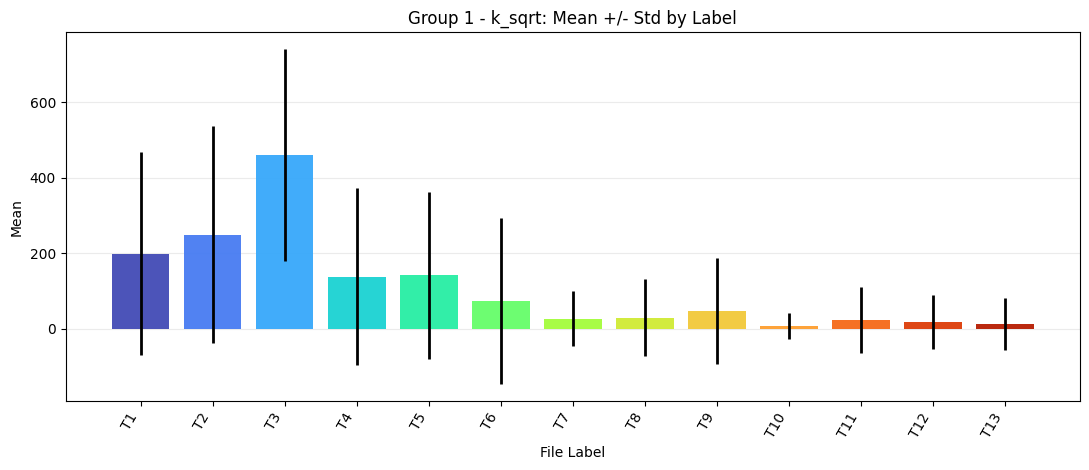

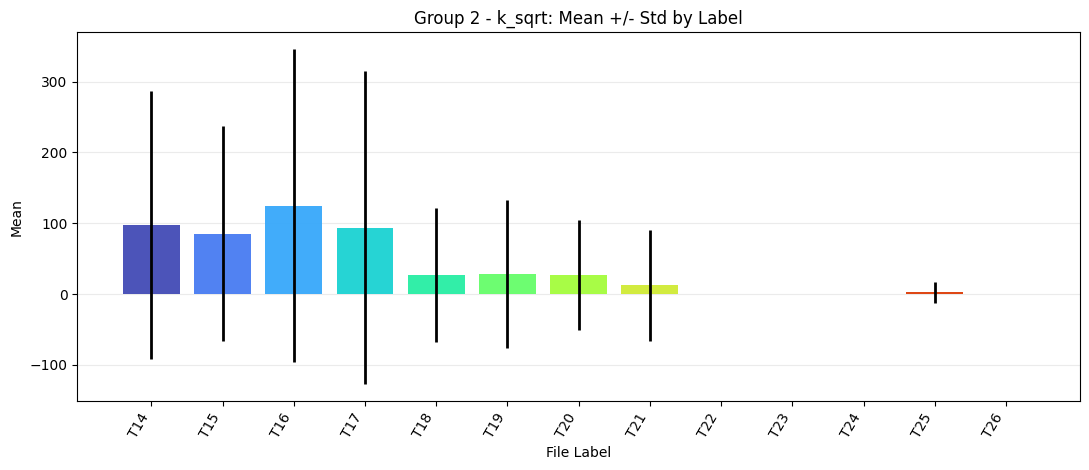

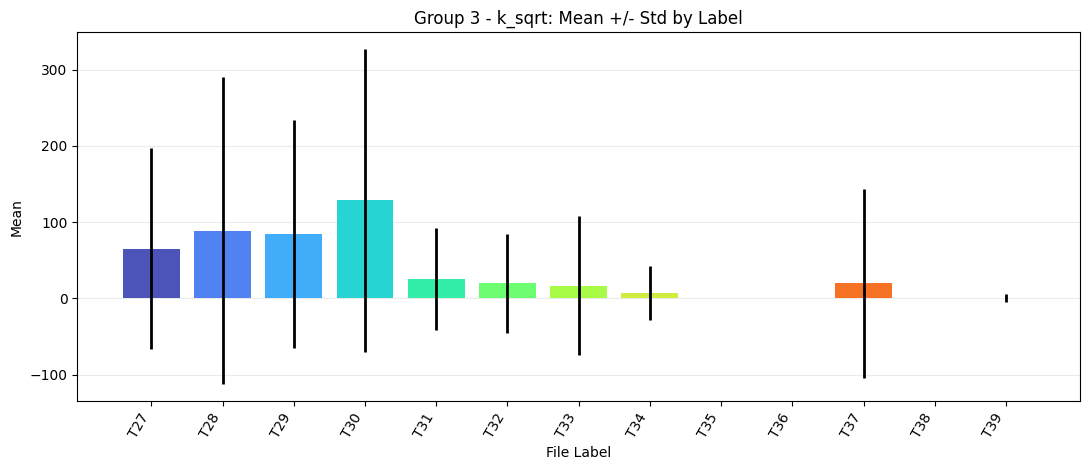

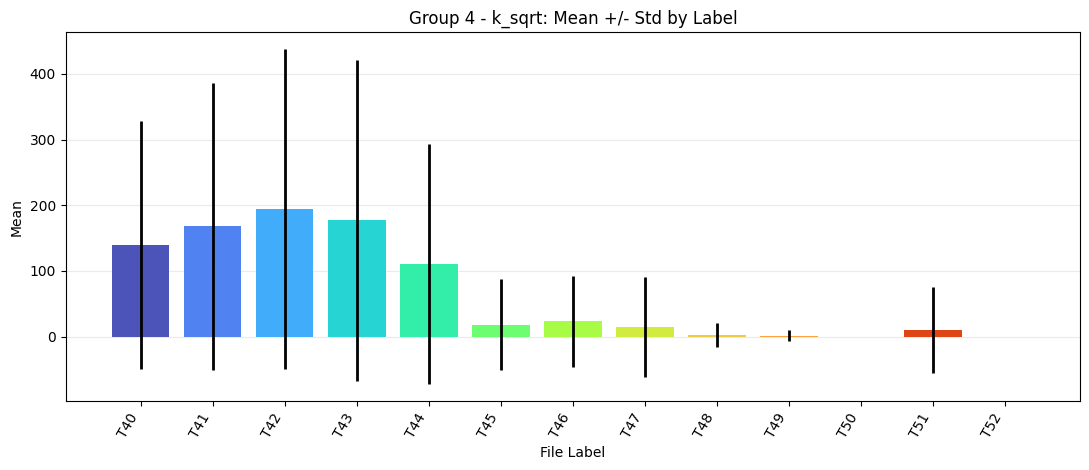

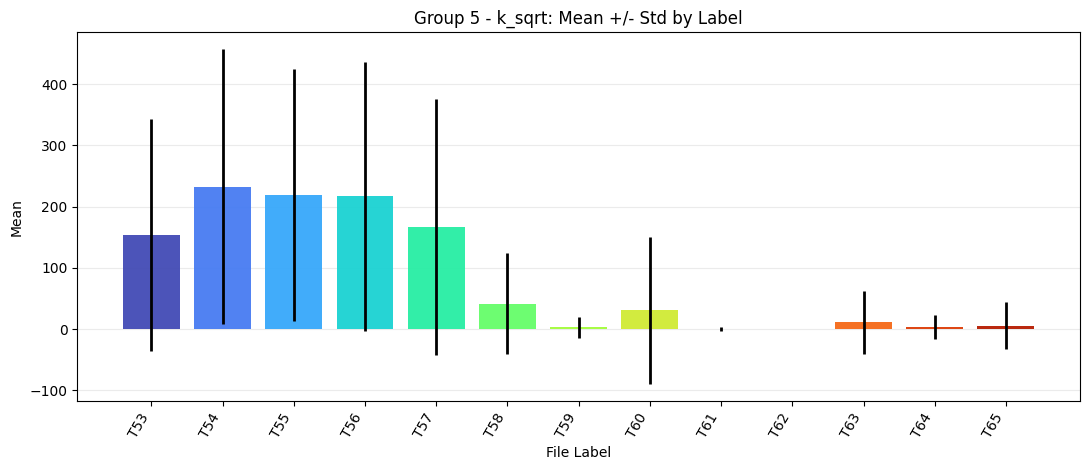

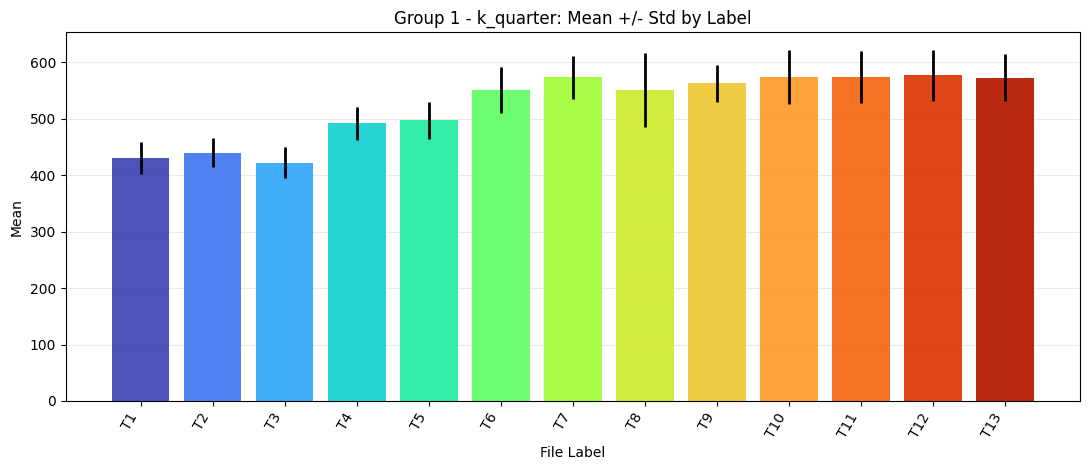

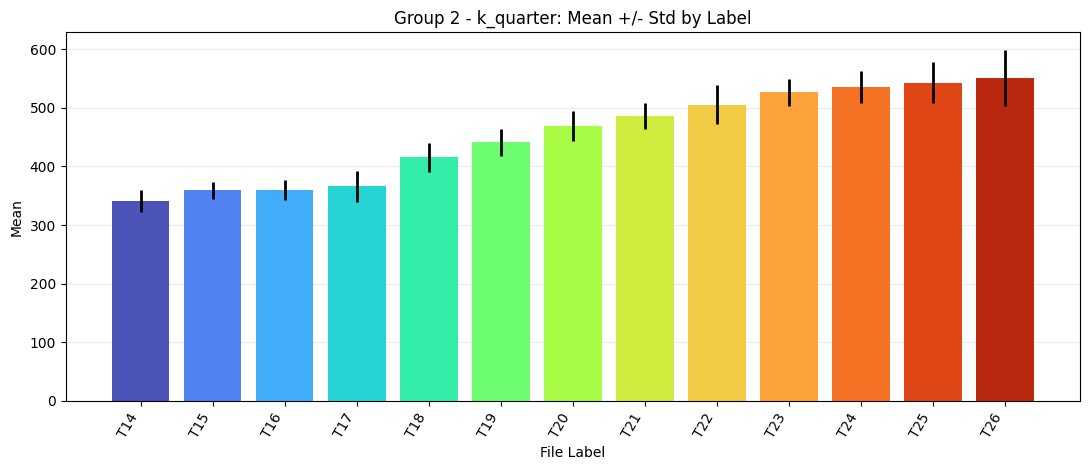

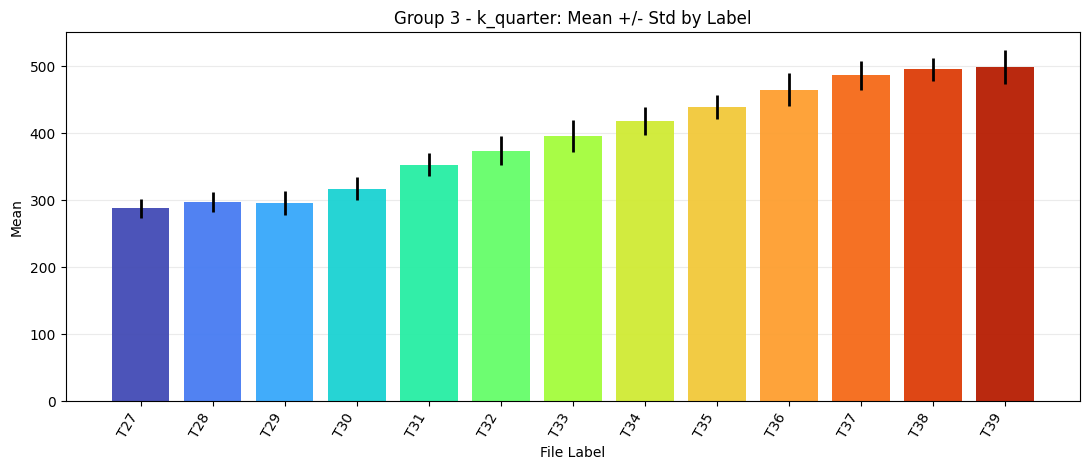

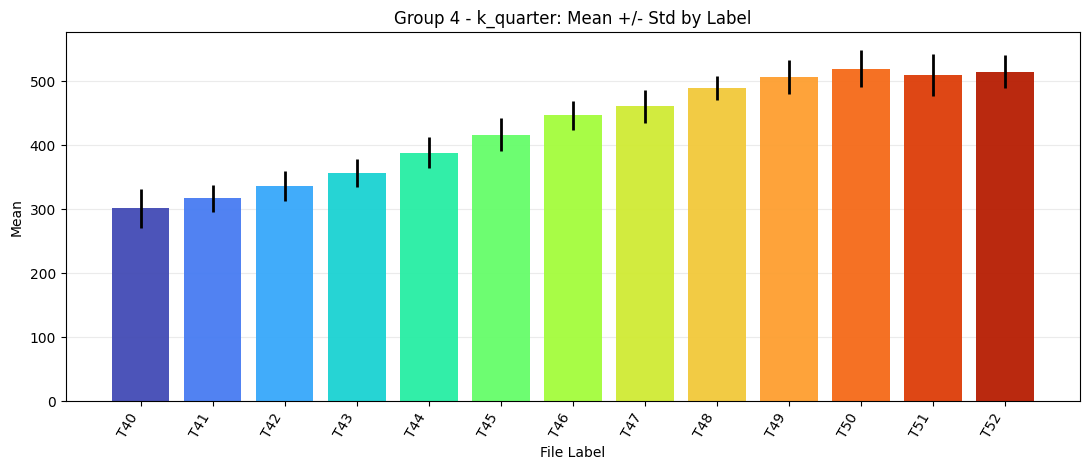

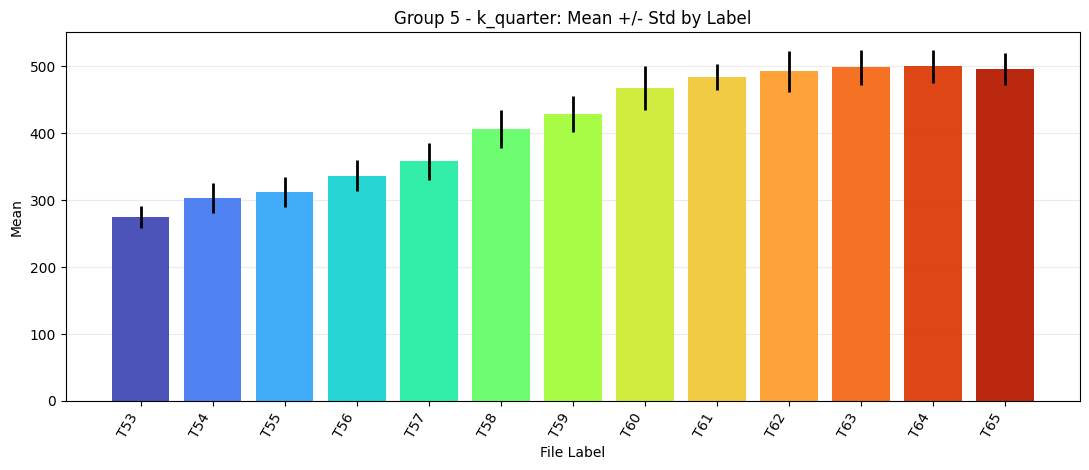

In [69]:
# One plot per group (last cell): clean style, no huge global legend
if "stats_df" not in globals() or stats_df.empty:
    raise RuntimeError("Run the previous stats cell first to build stats_df.")

def _group_sort_key(g):
    m = re.search(r"(\d+)", str(g))
    return int(m.group(1)) if m else 10**9

metrics_to_plot = ["k_sqrt", "k_quarter"]
df_plot = stats_df[stats_df["metric"].isin(metrics_to_plot)].copy()

for metric in metrics_to_plot:
    dfm = df_plot[df_plot["metric"] == metric].copy()
    if dfm.empty:
        continue

    groups = sorted(dfm["group"].unique(), key=_group_sort_key)

    for group_name in groups:
        gdf = dfm[dfm["group"] == group_name].copy()
        gdf = gdf.sort_values("label", key=lambda s: s.map(label_sort_key)).reset_index(drop=True)
        if gdf.empty:
            continue

        x = np.arange(len(gdf))
        colors = plt.colormaps["turbo"](np.linspace(0.08, 0.92, len(gdf)))

        fig, ax = plt.subplots(figsize=(11, 4.8))
        ax.bar(x, gdf["mean"].to_numpy(), color=colors, edgecolor="none", alpha=0.95, zorder=2)
        ax.errorbar(x, gdf["mean"].to_numpy(), yerr=gdf["std"].to_numpy(), fmt="none", ecolor="black", elinewidth=2.0, capsize=0, zorder=3)

        ax.set_xticks(x)
        ax.set_xticklabels(gdf["label"], rotation=60, ha="right")
        ax.set_xlabel("File Label")
        ax.set_ylabel("Mean")
        ax.set_title(f"{group_name} - {metric}: Mean +/- Std by Label")
        ax.grid(axis="y", alpha=0.25, zorder=1)

        plt.tight_layout()
        plt.show()
        plt.close(fig)


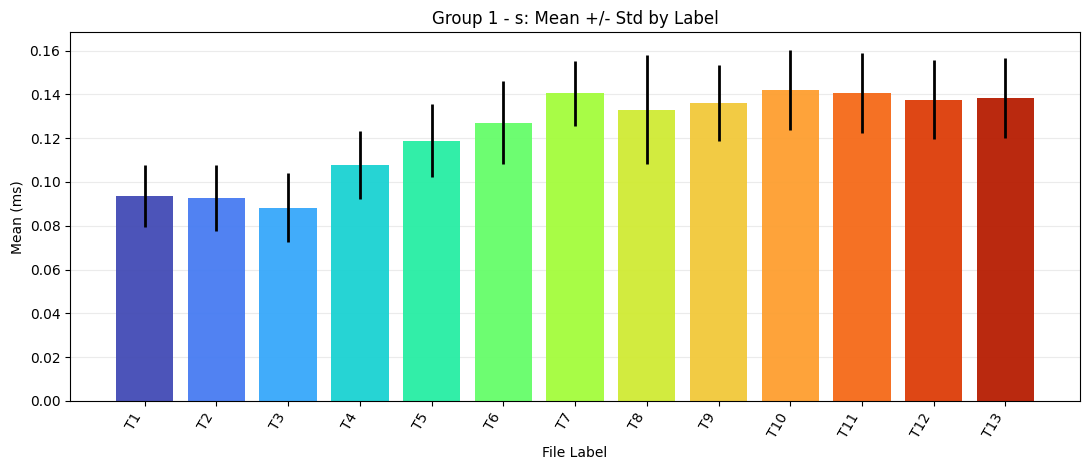

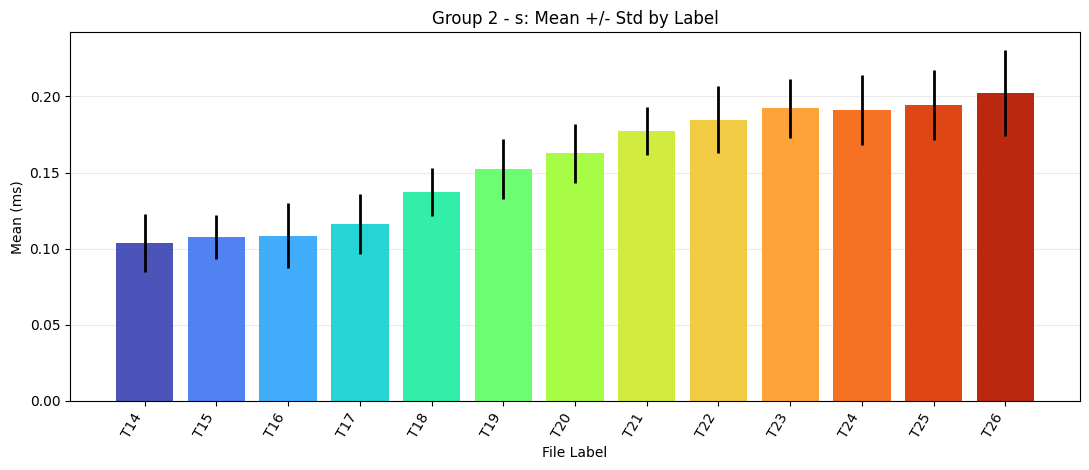

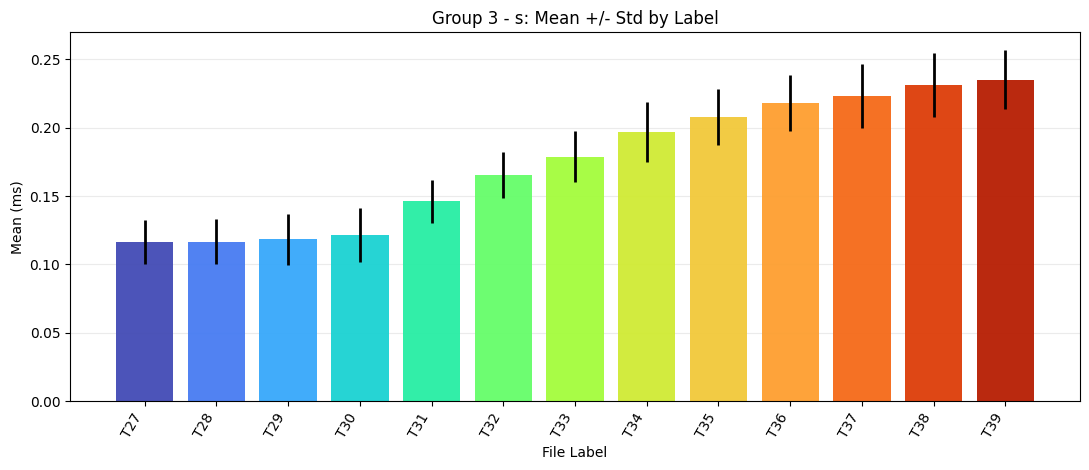

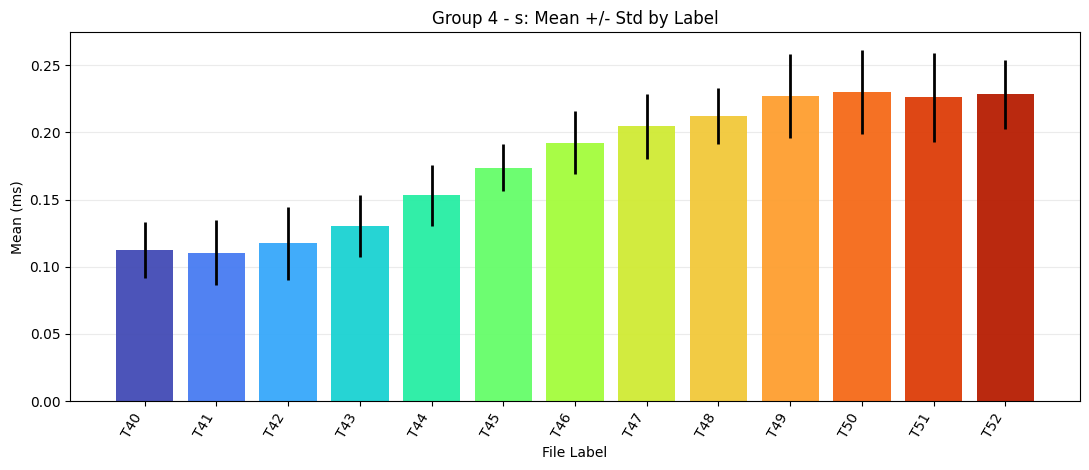

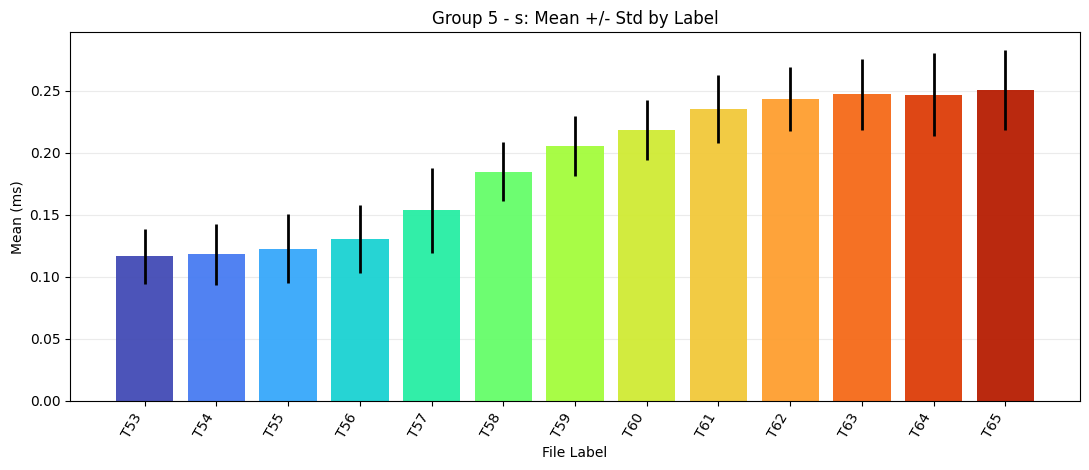

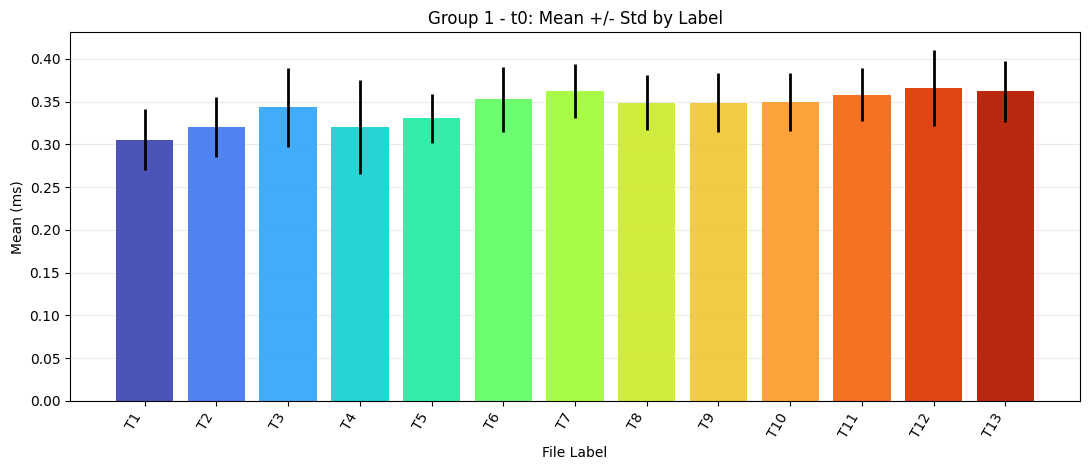

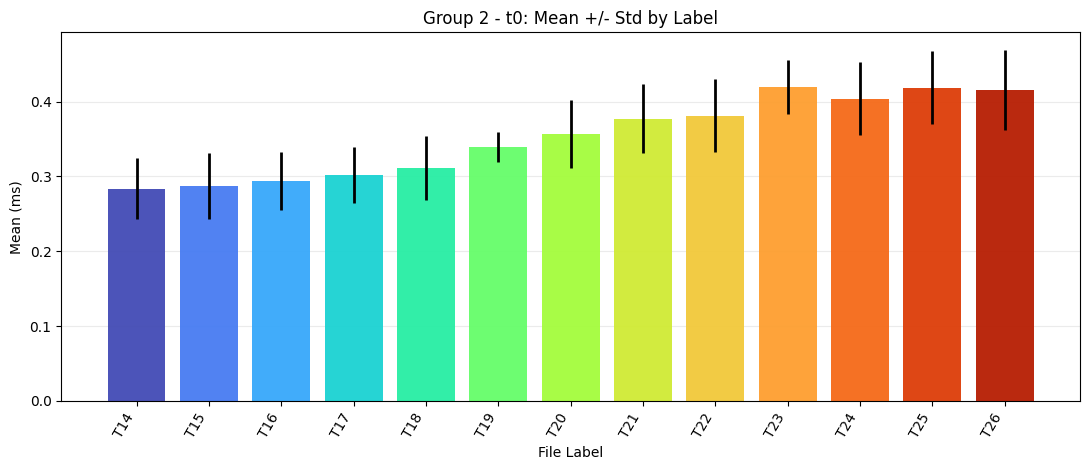

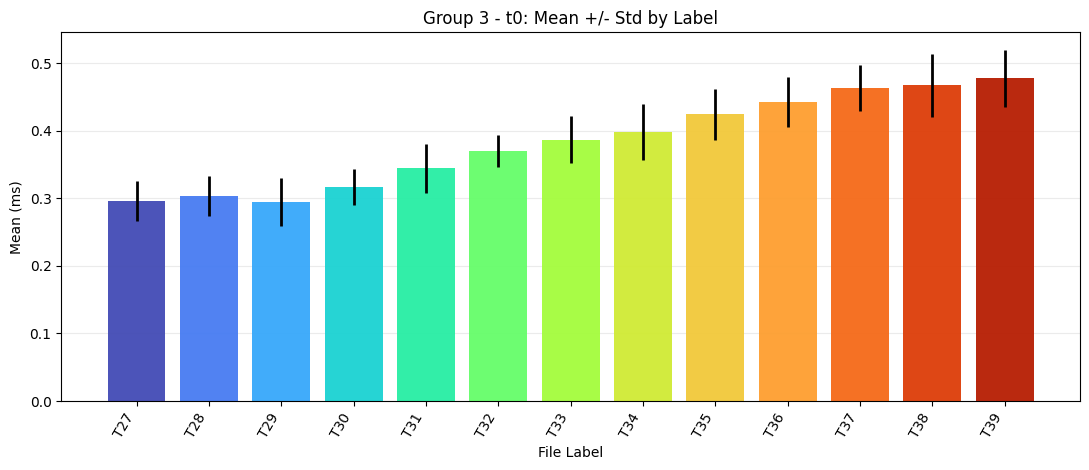

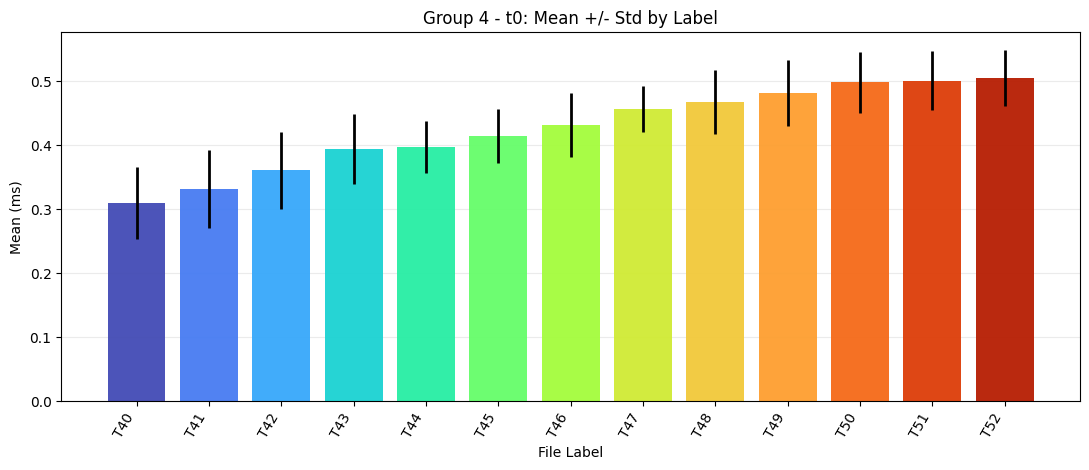

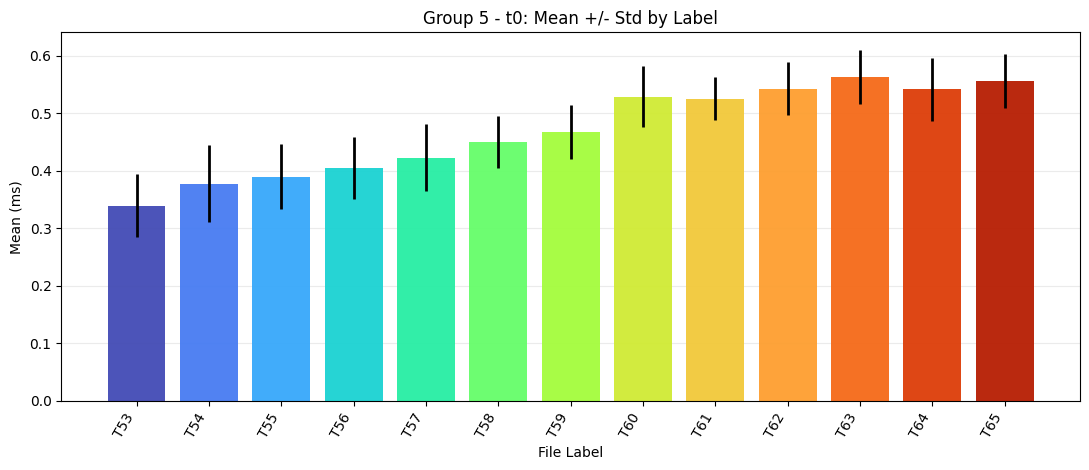

In [72]:
# One plot per group (last cell): clean style, no huge global legend
if "stats_df" not in globals() or stats_df.empty:
    raise RuntimeError("Run the previous stats cell first to build stats_df.")

def _group_sort_key(g):
    m = re.search(r"(\d+)", str(g))
    return int(m.group(1)) if m else 10**9

metrics_to_plot = ["s", "t0"]
df_plot = stats_df[stats_df["metric"].isin(metrics_to_plot)].copy()

for metric in metrics_to_plot:
    dfm = df_plot[df_plot["metric"] == metric].copy()
    if dfm.empty:
        continue

    groups = sorted(dfm["group"].unique(), key=_group_sort_key)

    for group_name in groups:
        gdf = dfm[dfm["group"] == group_name].copy()
        gdf = gdf.sort_values("label", key=lambda s: s.map(label_sort_key)).reset_index(drop=True)
        if gdf.empty:
            continue

        x = np.arange(len(gdf))
        colors = plt.colormaps["turbo"](np.linspace(0.08, 0.92, len(gdf)))

        fig, ax = plt.subplots(figsize=(11, 4.8))
        ax.bar(x, gdf["mean"].to_numpy(), color=colors, edgecolor="none", alpha=0.95, zorder=2)
        ax.errorbar(x, gdf["mean"].to_numpy(), yerr=gdf["std"].to_numpy(), fmt="none", ecolor="black", elinewidth=2.0, capsize=0, zorder=3)

        ax.set_xticks(x)
        ax.set_xticklabels(gdf["label"], rotation=60, ha="right")
        ax.set_xlabel("File Label")
        ax.set_ylabel("Mean (ms)")
        ax.set_title(f"{group_name} - {metric}: Mean +/- Std by Label")
        ax.grid(axis="y", alpha=0.25, zorder=1)

        plt.tight_layout()
        plt.show()
        plt.close(fig)

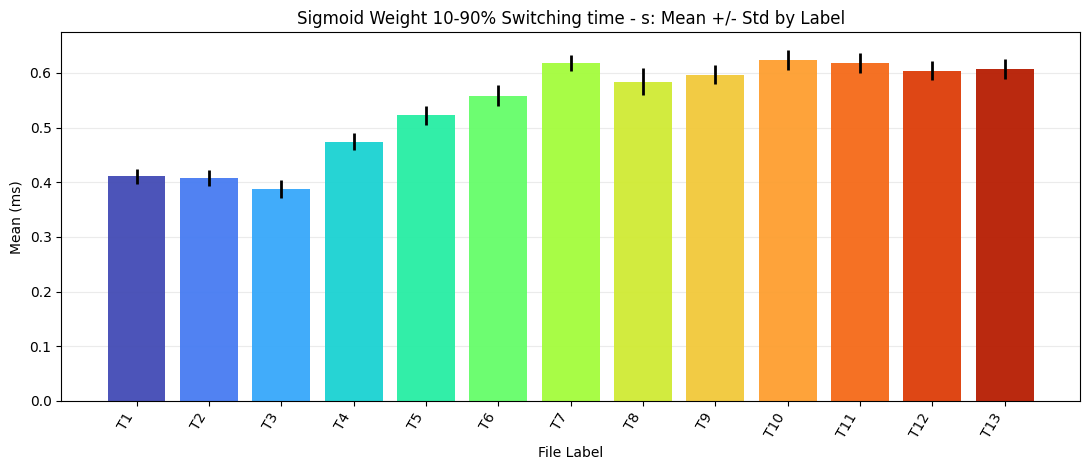

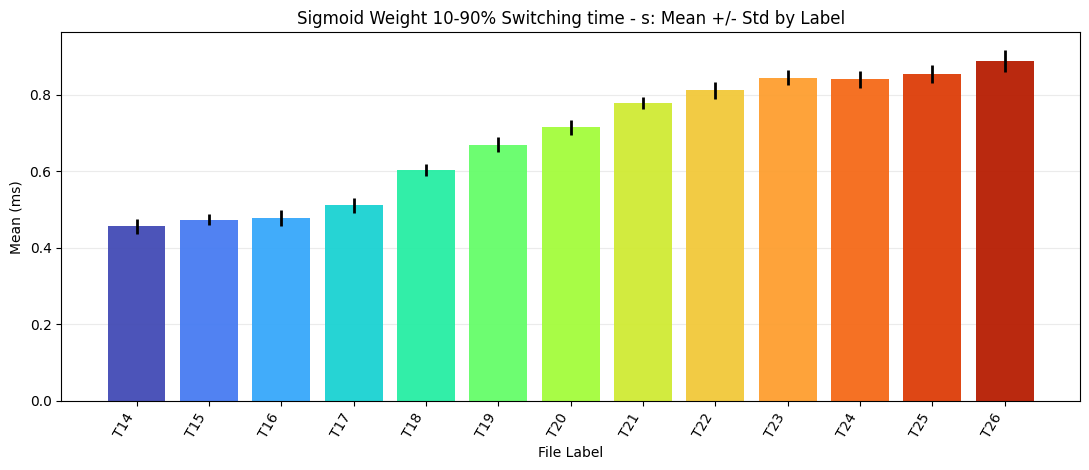

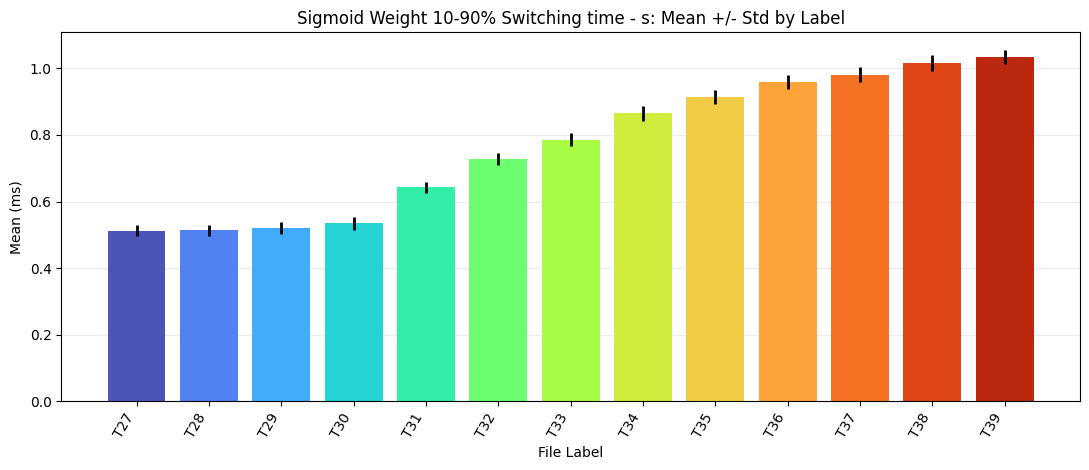

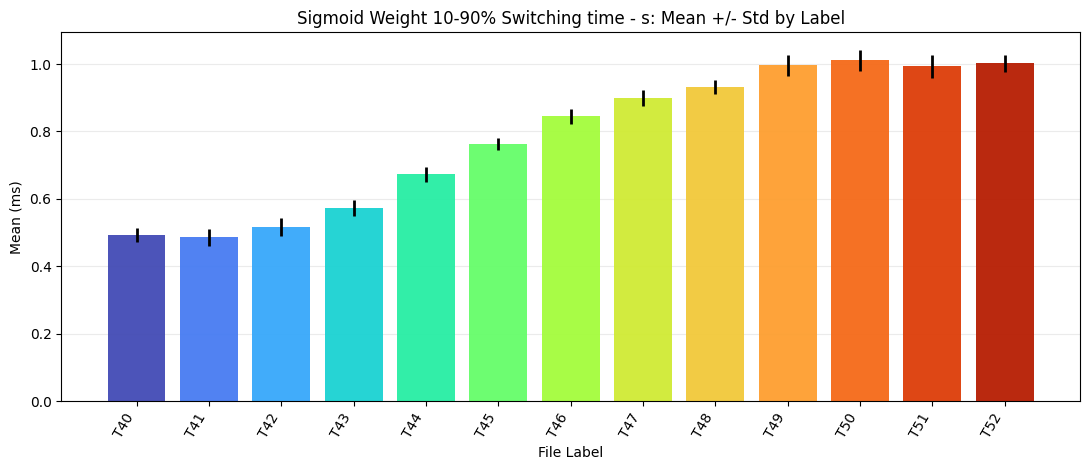

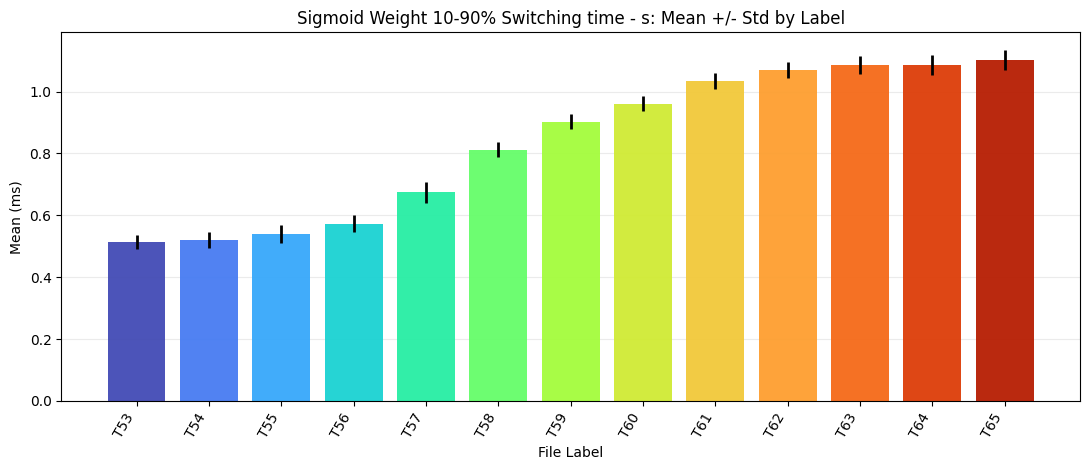

In [73]:
# One plot per group (last cell): clean style, no huge global legend
if "stats_df" not in globals() or stats_df.empty:
    raise RuntimeError("Run the previous stats cell first to build stats_df.")

def _group_sort_key(g):
    m = re.search(r"(\d+)", str(g))
    return int(m.group(1)) if m else 10**9

metrics_to_plot = ["s"]
df_plot = stats_df[stats_df["metric"].isin(metrics_to_plot)].copy()

for metric in metrics_to_plot:
    dfm = df_plot[df_plot["metric"] == metric].copy()
    if dfm.empty:
        continue

    groups = sorted(dfm["group"].unique(), key=_group_sort_key)

    for group_name in groups:
        gdf = dfm[dfm["group"] == group_name].copy()
        gdf = gdf.sort_values("label", key=lambda s: s.map(label_sort_key)).reset_index(drop=True)
        if gdf.empty:
            continue

        x = np.arange(len(gdf))
        colors = plt.colormaps["turbo"](np.linspace(0.08, 0.92, len(gdf)))

        fig, ax = plt.subplots(figsize=(11, 4.8))
        ax.bar(x, 4.3944*gdf["mean"].to_numpy(), color=colors, edgecolor="none", alpha=0.95, zorder=2)
        ax.errorbar(x, 4.3944*gdf["mean"].to_numpy(), yerr=gdf["std"].to_numpy(), fmt="none", ecolor="black", elinewidth=2.0, capsize=0, zorder=3)

        ax.set_xticks(x)
        ax.set_xticklabels(gdf["label"], rotation=60, ha="right")
        ax.set_xlabel("File Label")
        ax.set_ylabel("Mean (ms)")
        ax.set_title(f"Sigmoid Weight 10-90% Switching time - {metric}: Mean +/- Std by Label")
        ax.grid(axis="y", alpha=0.25, zorder=1)

        plt.tight_layout()
        plt.show()
        plt.close(fig)